# Quantified Self Project: 
# Personal Flying and Working Correlations 
by Jackie Ramsey  
CPSC 222, Fall 2021

## Project Domain:  
My project domain is aviation, more specifically flying data. I am interested in this domain because I am a pilot and am working on my certifications. When I am home, I also work at the flight school that I learn at. I was interested in the correlation between my flying hours data and my work hours data that I have been collecting this past summer. 

### Dataset:
* flying_logbook.csv
    * Date
    * Total Hours - total hours flying per day
    * Dual Received - hours flying with instructor
    * Pilot in Command - hours flying without instructor
    * Day - hours flying during day
    * Night - hours flying during night
    * Cross-Country - hours flying a distance further than 25nm from departure point
    * Instrument - hours flying using instruments
    * Day Landings - amount of landings during the day
    * Night Landings - amount of landings during the night
* work_hours.csv
    * Date
    * Work - if i worked (yes/no)
    * Work Hours - total hours of work

### Classify
* 

### Potential Impacts

### Stakeholders
* flight instructor
* designated pilot examiners
* boss or hiring 

## Data Analysis


In [10]:
from numpy.core.fromnumeric import mean
import pandas as pd
from pandas.io.parsers import read_csv
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats

# load data into DataFrame
flying_logbook = pd.read_csv("flying_logbook.csv")
work_hours = pd.read_csv("work_hours.csv")

flying_logbook_df = pd.DataFrame(flying_logbook)
work_hours_df = pd.DataFrame(work_hours)

### Merge Data
Data merged on "Date"

In [11]:
# merge data
merge_df = flying_logbook_df.merge(work_hours_df, on="Date")
merge_df = pd.DataFrame(merge_df)

merge_df.to_csv("merge.csv")

### Clean Data
* remove rows where i do not work or fly on that day
* add column that says whether or no I fly
* add column that says whether I fly and work on thaat day

Challenges:
It was difficult to sort out...

In [12]:
# clean data 
work_or_flying = []
flying = []
for i in range(len(merge_df)):
    if merge_df.at[i, "Work"] == "No" and merge_df.at[i, "Total Hours"] == 0:
        work_or_flying.append("NaN")
        flying.append("NaN")
    elif merge_df.at[i, "Work"] == "Yes" and merge_df.at[i, "Total Hours"] != 0:
        work_or_flying.append("Yes")
        flying.append("Yes")
    else:
        work_or_flying.append("No")
        if merge_df.at[i, "Work"] == "No" and merge_df.at[i, "Total Hours"] != 0:
            flying.append("Yes")
        else:
            flying.append("No")

merge_df["Fly"] = flying
merge_df["Fly and Work"] = work_or_flying

for i in range(len(work_or_flying)):
    if work_or_flying[i] == "NaN":
        merge_df = merge_df.drop(i)

merge_df.reset_index(inplace=True)
merge_df = merge_df.drop("index", axis=1)
merge_df.to_csv("merge_cleaned.csv")

### Aggregation
* split, apply, combine
    * Flight lessons on days I also worked

In [13]:
# split, apply, combine
# group by Work and find average flying time
work_df = merge_df.groupby("Work")
daily_hours_ser = pd.Series(dtype=float)
daily_hours_ser = work_df["Dual Received"].mean()
print(daily_hours_ser)

Work
No     2.035294
Yes    0.738462
Name: Dual Received, dtype: float64


### Visualizations

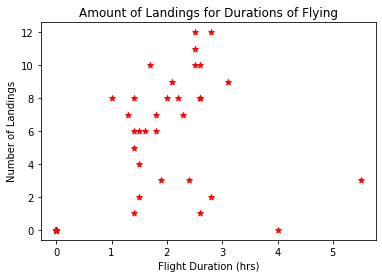

In [14]:
# scatter plot of amount of landings per flight
plt.figure()
y1 = merge_df["Day Landings"].squeeze()
x1 = merge_df["Total Hours"].squeeze()
plt.scatter(x1, y1, color="red", marker="*")
plt.title("Amount of Landings for Durations of Flying")
plt.xlabel("Flight Duration (hrs)")
plt.ylabel("Number of Landings")
plt.show()

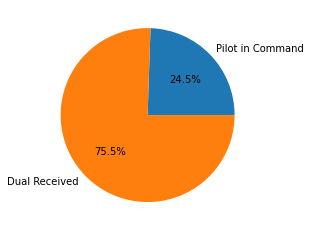

In [15]:
# pi chart of pic or dual
plt.figure()
x = merge_df["Pilot in Command"].squeeze()
y = merge_df["Dual Received"].squeeze()
xbar = mean(x)
ybar = mean(y)
arr = [xbar, ybar]
label_types = ["Pilot in Command", "Dual Received"]
plt.pie(arr, labels=label_types, autopct="%1.1f%%")
plt.show()

### Statistical Hypotheses

In [16]:
# did i fly more when I had work or when I had no work
both = []
flyonly = []
for i in range(len(merge_df)):
    if merge_df.at[i, "Fly and Work"] == "Yes":
        both.append(merge_df.at[i, "Total Hours"])
    if merge_df.at[i, "Fly and Work"] == "No" and merge_df.at[i, "Fly"] == "Yes":
        flyonly.append(merge_df.at[i, "Total Hours"])
both = pd.Series(both)
flyonly = pd.Series(flyonly)

# Step 1
# H0: flyonly hrs > flyandwork hrs
# H1: flyonly hrs <= flyandwork hrs

# Step 2
# los = 0.05

# Step 3
# two sample, independant one tail
n1 = len(flyonly)
n2 = len(both)
df = n1 + n2 -2

# Step 4
sp2 = ((n1 - 1) * flyonly.std() ** 2 + (n2 - 1) * both.std() ** 2) / df
t = (flyonly.mean() - both.mean()) / np.sqrt(sp2 * (1 / n1 + 1 / n2))
t, p = stats.ttest_ind(flyonly, both)
print("sp2:", sp2)
print("t:", t)
print("p:", p/2)

# Step 5
if p/2 < 0.05:
    print("Reject H0")
else:
    print("Do not reject H0")

sp2: 0.8012354497354497
t: 0.32594622369796916
p: 0.373363917499927
Do not reject H0


In [17]:
# instrument training had longer flights than normal training
# two sample, independant one tail
ifr = []
vfr = []
for i in range(len(merge_df)):
    if merge_df.at[i, "Instrument"] != 0:
        ifr.append(merge_df.at[i, "Total Hours"])
    else:
        vfr.append(merge_df.at[i, "Total Hours"])
ifr = pd.Series(ifr)
vfr = pd.Series(vfr)

n1 = len(ifr)
n2 = len(vfr)
df = n1 + n2 -2

# Step 4
sp2 = ((n1 - 1) * ifr.std() ** 2 + (n2 - 1) * vfr.std() ** 2) / df
t = (ifr.mean() - vfr.mean()) / np.sqrt(sp2 * (1 / n1 + 1 / n2))
t, p = stats.ttest_ind(ifr, vfr)
print("sp2:", sp2)
print("t:", t)
print("p:", p/2)

# Step 5
if p < 0.05:
    print("Reject H0")
else:
    print("Do not reject H0")

sp2: 1.3697951048951051
t: 3.5928014951617993
p: 0.0003494370267483079
Reject H0


### Classifiers
* kNN